# **Importing packages**

In [ ]:
!pip install 'networkx==3.1'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.6 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.3
    Uninstalling networkx-3.3:
      Successfully uninstalled networkx-3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.algorithms import tree
import matplotlib.cm as cm
import community.community_louvain as lv
from sklearn.metrics.cluster import v_measure_score


# **Reading datasets**

In [ ]:
crypto_data = pd.read_csv("data/crypto_30min_filled_missing_value(ffill).csv")
stock_data = pd.read_csv("data/stock_30min_official_trading_filled_missing(ffill).csv")
index_data = pd.read_csv("data/etfs_filled.csv").drop(columns = ["Unnamed: 0"])

# Remove some ETFs
remove_assets = ["GOVT","IEF", "IEI", "UVXY", "VIXM", "VIXY","VXX"]
index_data = index_data.drop(columns = remove_assets)


In [ ]:
# Set the index column of each dataset to "date"
crypto_data = crypto_data.set_index("date")
stock_data = stock_data.set_index("date")
index_data = index_data.set_index("date")

In [ ]:
# Get asset names
stock_names = list(stock_data.columns)
crypto_names = list(crypto_data.columns)
index_names = list(index_data.columns)
asset_names = stock_names + crypto_names + index_names

In [ ]:
# Merge all three datasets to one dataset
all_data = pd.concat([stock_data, crypto_data, index_data], axis =1, join = "inner")

**Convert to return values**

In [ ]:
data = all_data.to_numpy() # Convert to numpy
names = all_data.columns
# Find log-returns
original = data[:-1]
onelag = data[1:]
logreturns = np.log(onelag) - np.log(original)

return_data = pd.DataFrame(data = logreturns, columns = asset_names)
return_data["date"] = all_data.reset_index()["date"][1:].values
return_data["date"] = pd.to_datetime(return_data["date"])
return_data = return_data.set_index(['date'])

In [ ]:
return_data_ped5 = return_data.drop(columns = ["UST"]) # UST has been dead since this time so we remove this cryptocurrency from the dataset during this period
names_ped5 = return_data_ped5.columns

# **Minimum Spanning Tree and Community Detection**

**Correlation matrix of all assets over the entire period**

In [ ]:
return_numpy = return_data.to_numpy()
me = return_numpy.mean(axis = 0)
st = return_numpy.std(axis = 0)
st[st<0.0001] = 0.0001 # Make sure that the denominator is not zero

normalized = (return_numpy - me)/st

# find cross-correlation matrix
C = (1/len(return_numpy))*(normalized.T@normalized)


C[C>0.9999] = 1.0

Text(0.5, 1.0, 'Correlation between stocks, cryptocurrencies and US ETFs using Pearson')

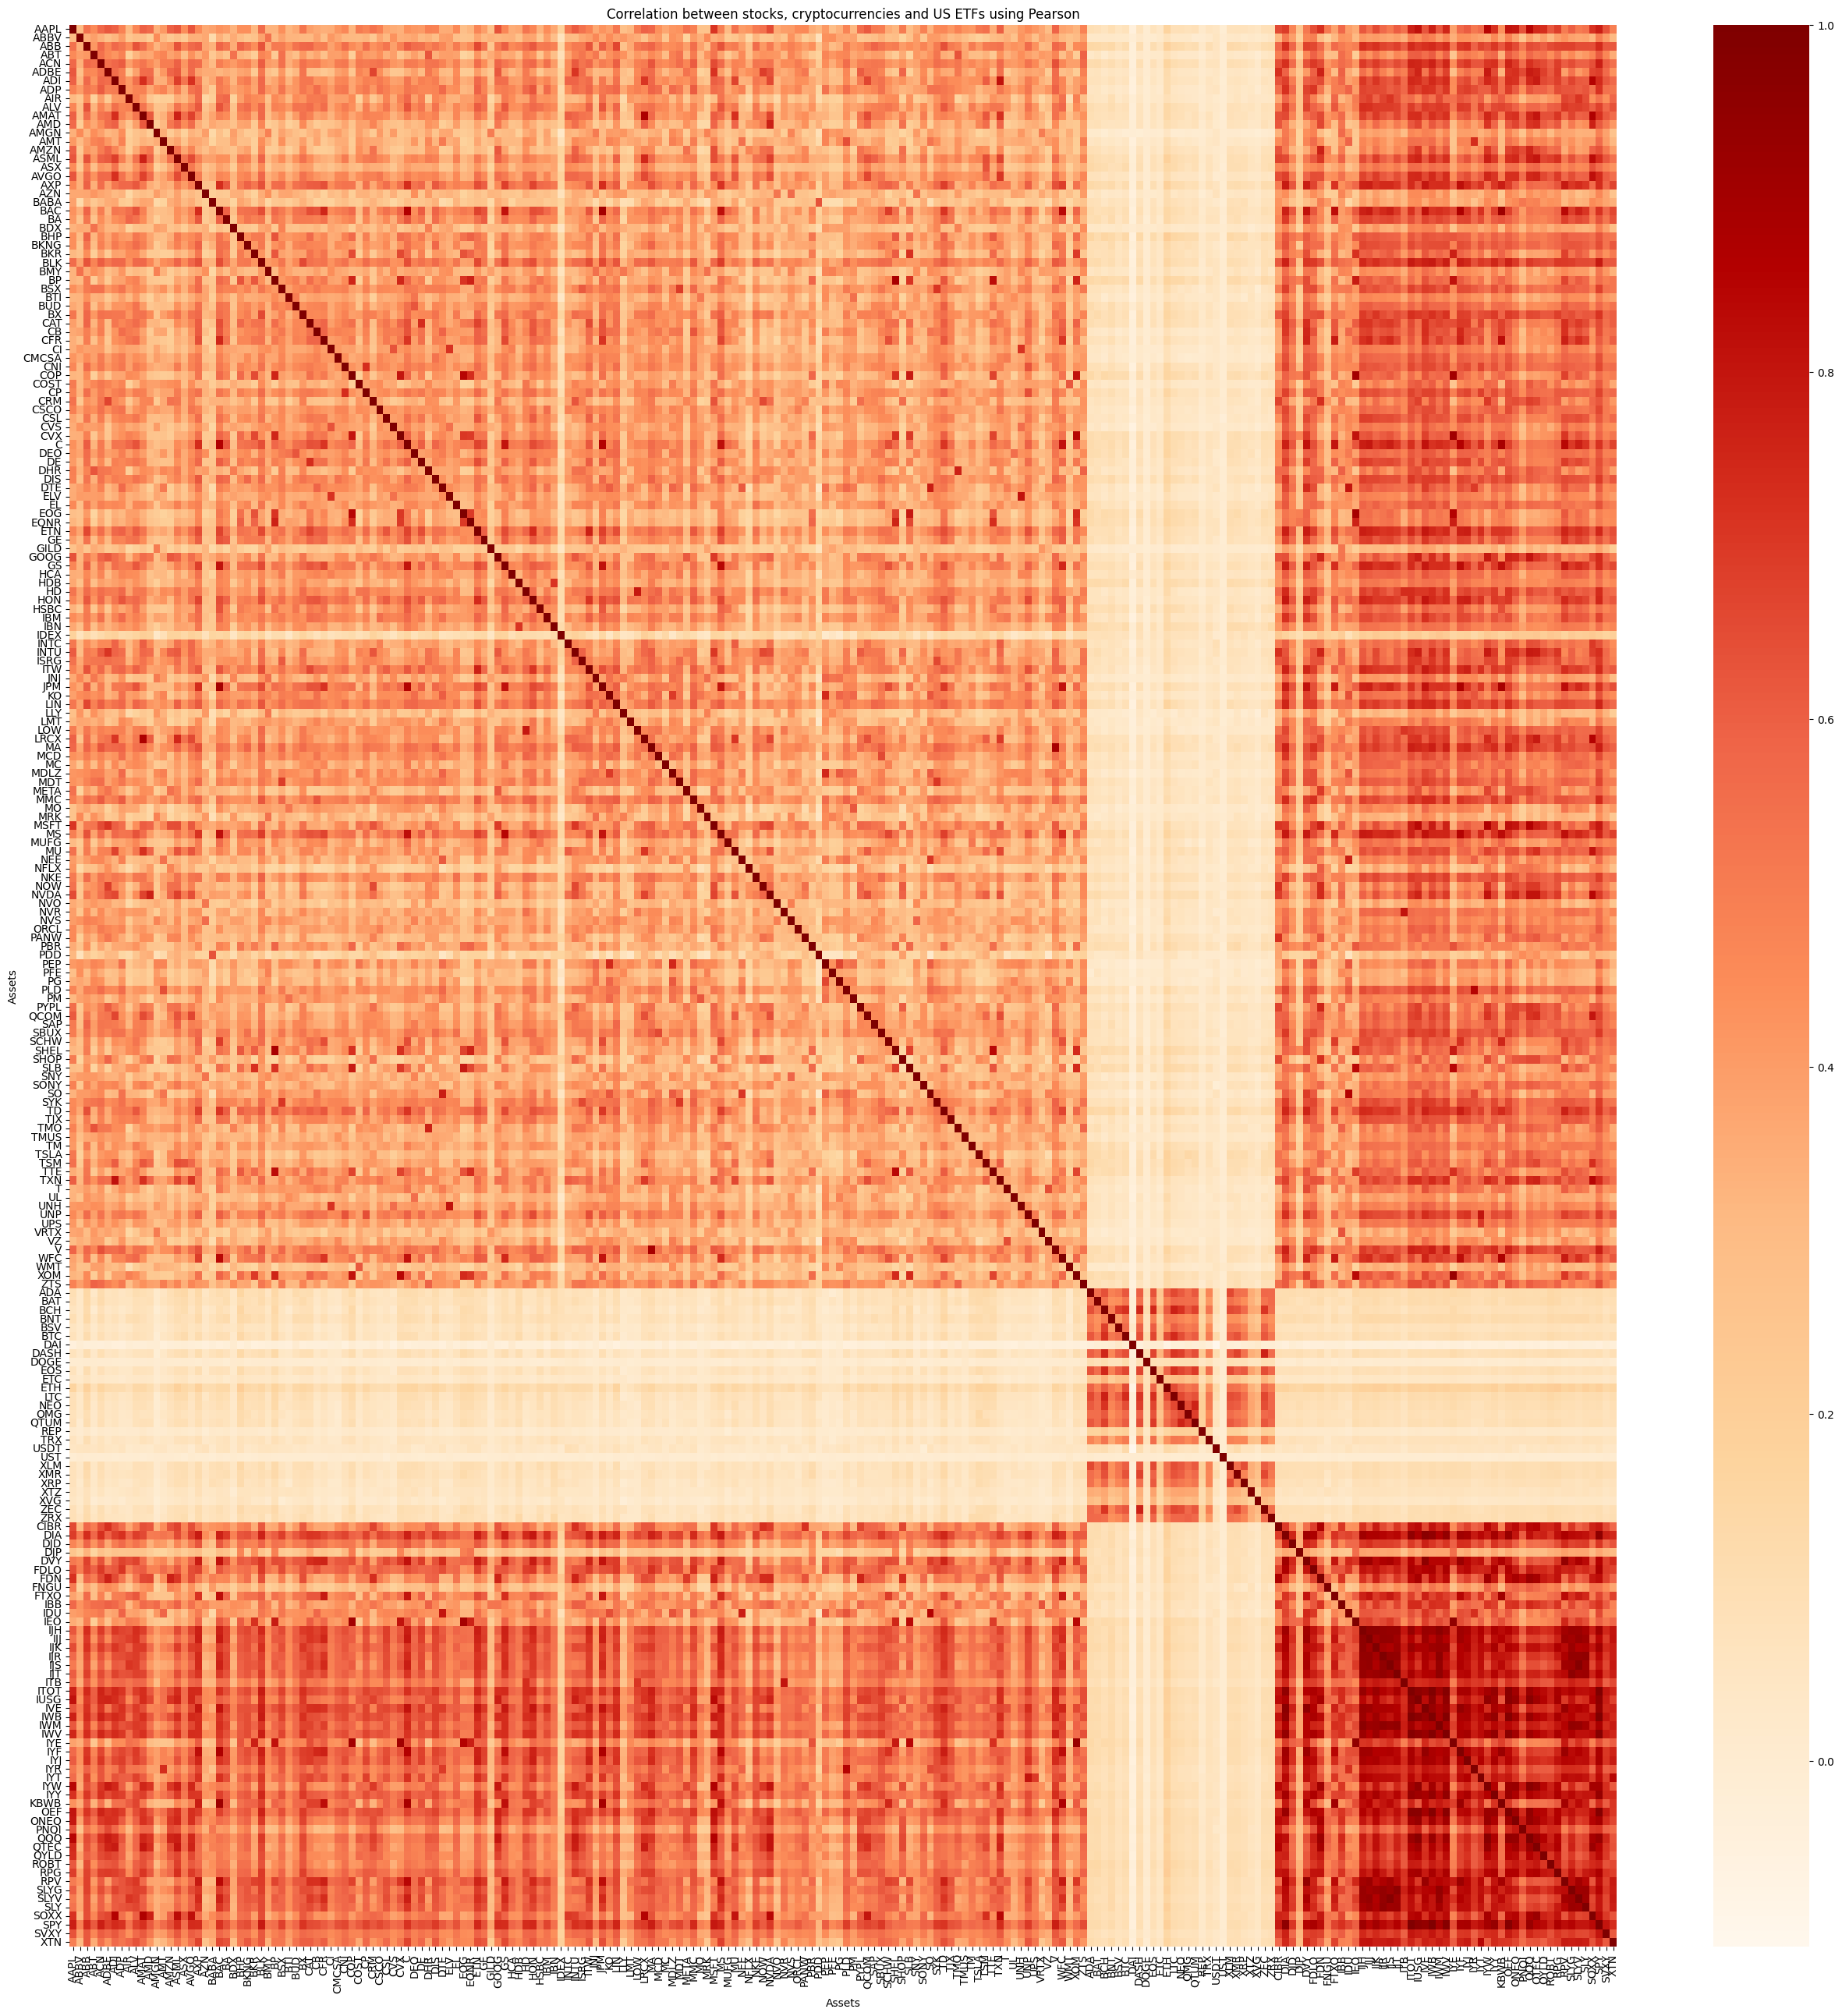

In [ ]:
# Plot the correlation matrix

fig, ax = plt.subplots(figsize=(32,32))
ax = sns.heatmap(C, cmap = 'OrRd', xticklabels= asset_names, yticklabels= asset_names, annot = False, ax = ax)
plt.xlabel("Assets")
plt.ylabel("Assets")
plt.title("Correlation between stocks, cryptocurrencies and US ETFs using Pearson")

The code below is to find the minimum spanning tree and then perform the community detection on this tree.

As explained in our paper, we split the our data into 5 distinct periods, corresponding to a major event occurred in financial markets at that time. Thus, depends on which period you want to focus on, the corresponding specification in the code needs to modified. The list of periods are listed below, along with the corresponding specification in the code.

+ Pre-Covid-19 : 04/2019 - 12/2019 -> return_data[:2464]
+ Covid-19     : 01/2020 - 06/2020 -> return_data[2464:4089]
+ Post-Covid-19: 07/2020 - 12/2020 -> return_data[4089:5741]
+ Bull market time: 01/2021 - 04/2022 -> return_data [5741:10077]
+ Ukraine-Russia conflict: 05/2022 - 05/2023 -> return_data[10077:]

An example below is made using the first period, i.e. Pre-Covid-19. Hence, the return_data[:2464] is used.

We note that the Ukraine-Russia conflict period only has 221 assets since the UST asset has been removed during this period due to its crash. Consequently, to run the below code for this period, please use the data named "return_data_ped5"



**Constructing Minimum Spanning Tree**

**First - forming a correlation matrix, as described earlier**

In [ ]:
return_interval = return_data[:2464].to_numpy()
me = return_interval.mean(axis = 0)
st = return_interval.std(axis = 0)
st[st<0.0001] = 0.0001 # Make sure that the denominator is not zero

normalized = (return_interval - me)/st

# find cross-correlation matrix
C = (1/len(return_interval))*(normalized.T@normalized)


C[C>0.9999] = 1.0

**Second - Transforming the correlation matrix to Distance matrix**

In [ ]:
D = np.sqrt(2*(1-C))
D[D<1e-7] = 0.0

**Third - Building a graph from the given distance matrix and extract the Minimum Spanning Tree from the graph**

In [ ]:
# Forming a graph from the distance matrix - this is the fully connected graph
Graph_asset = nx.from_numpy_array(D, create_using= nx.Graph)
# Extracting the Minimum Spanning Tree from the graph
MST =  tree.minimum_spanning_edges(Graph_asset, algorithm= "kruskal", data = True)
mst_graph = nx.Graph()
mst_graph.add_nodes_from(names)
# Adding the name of assets to the Minimum Spanning Tree
for (node1, node2, _) in MST:
  mst_graph.add_edge(names[node1], names[node2])


**Forth - Louvain Community Detection Algorithm**

In [ ]:
louvain_partition = lv.best_partition(mst_graph)

**Plotting the graph and community detection results**

<ipython-input-33-375b0d590f0a>:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



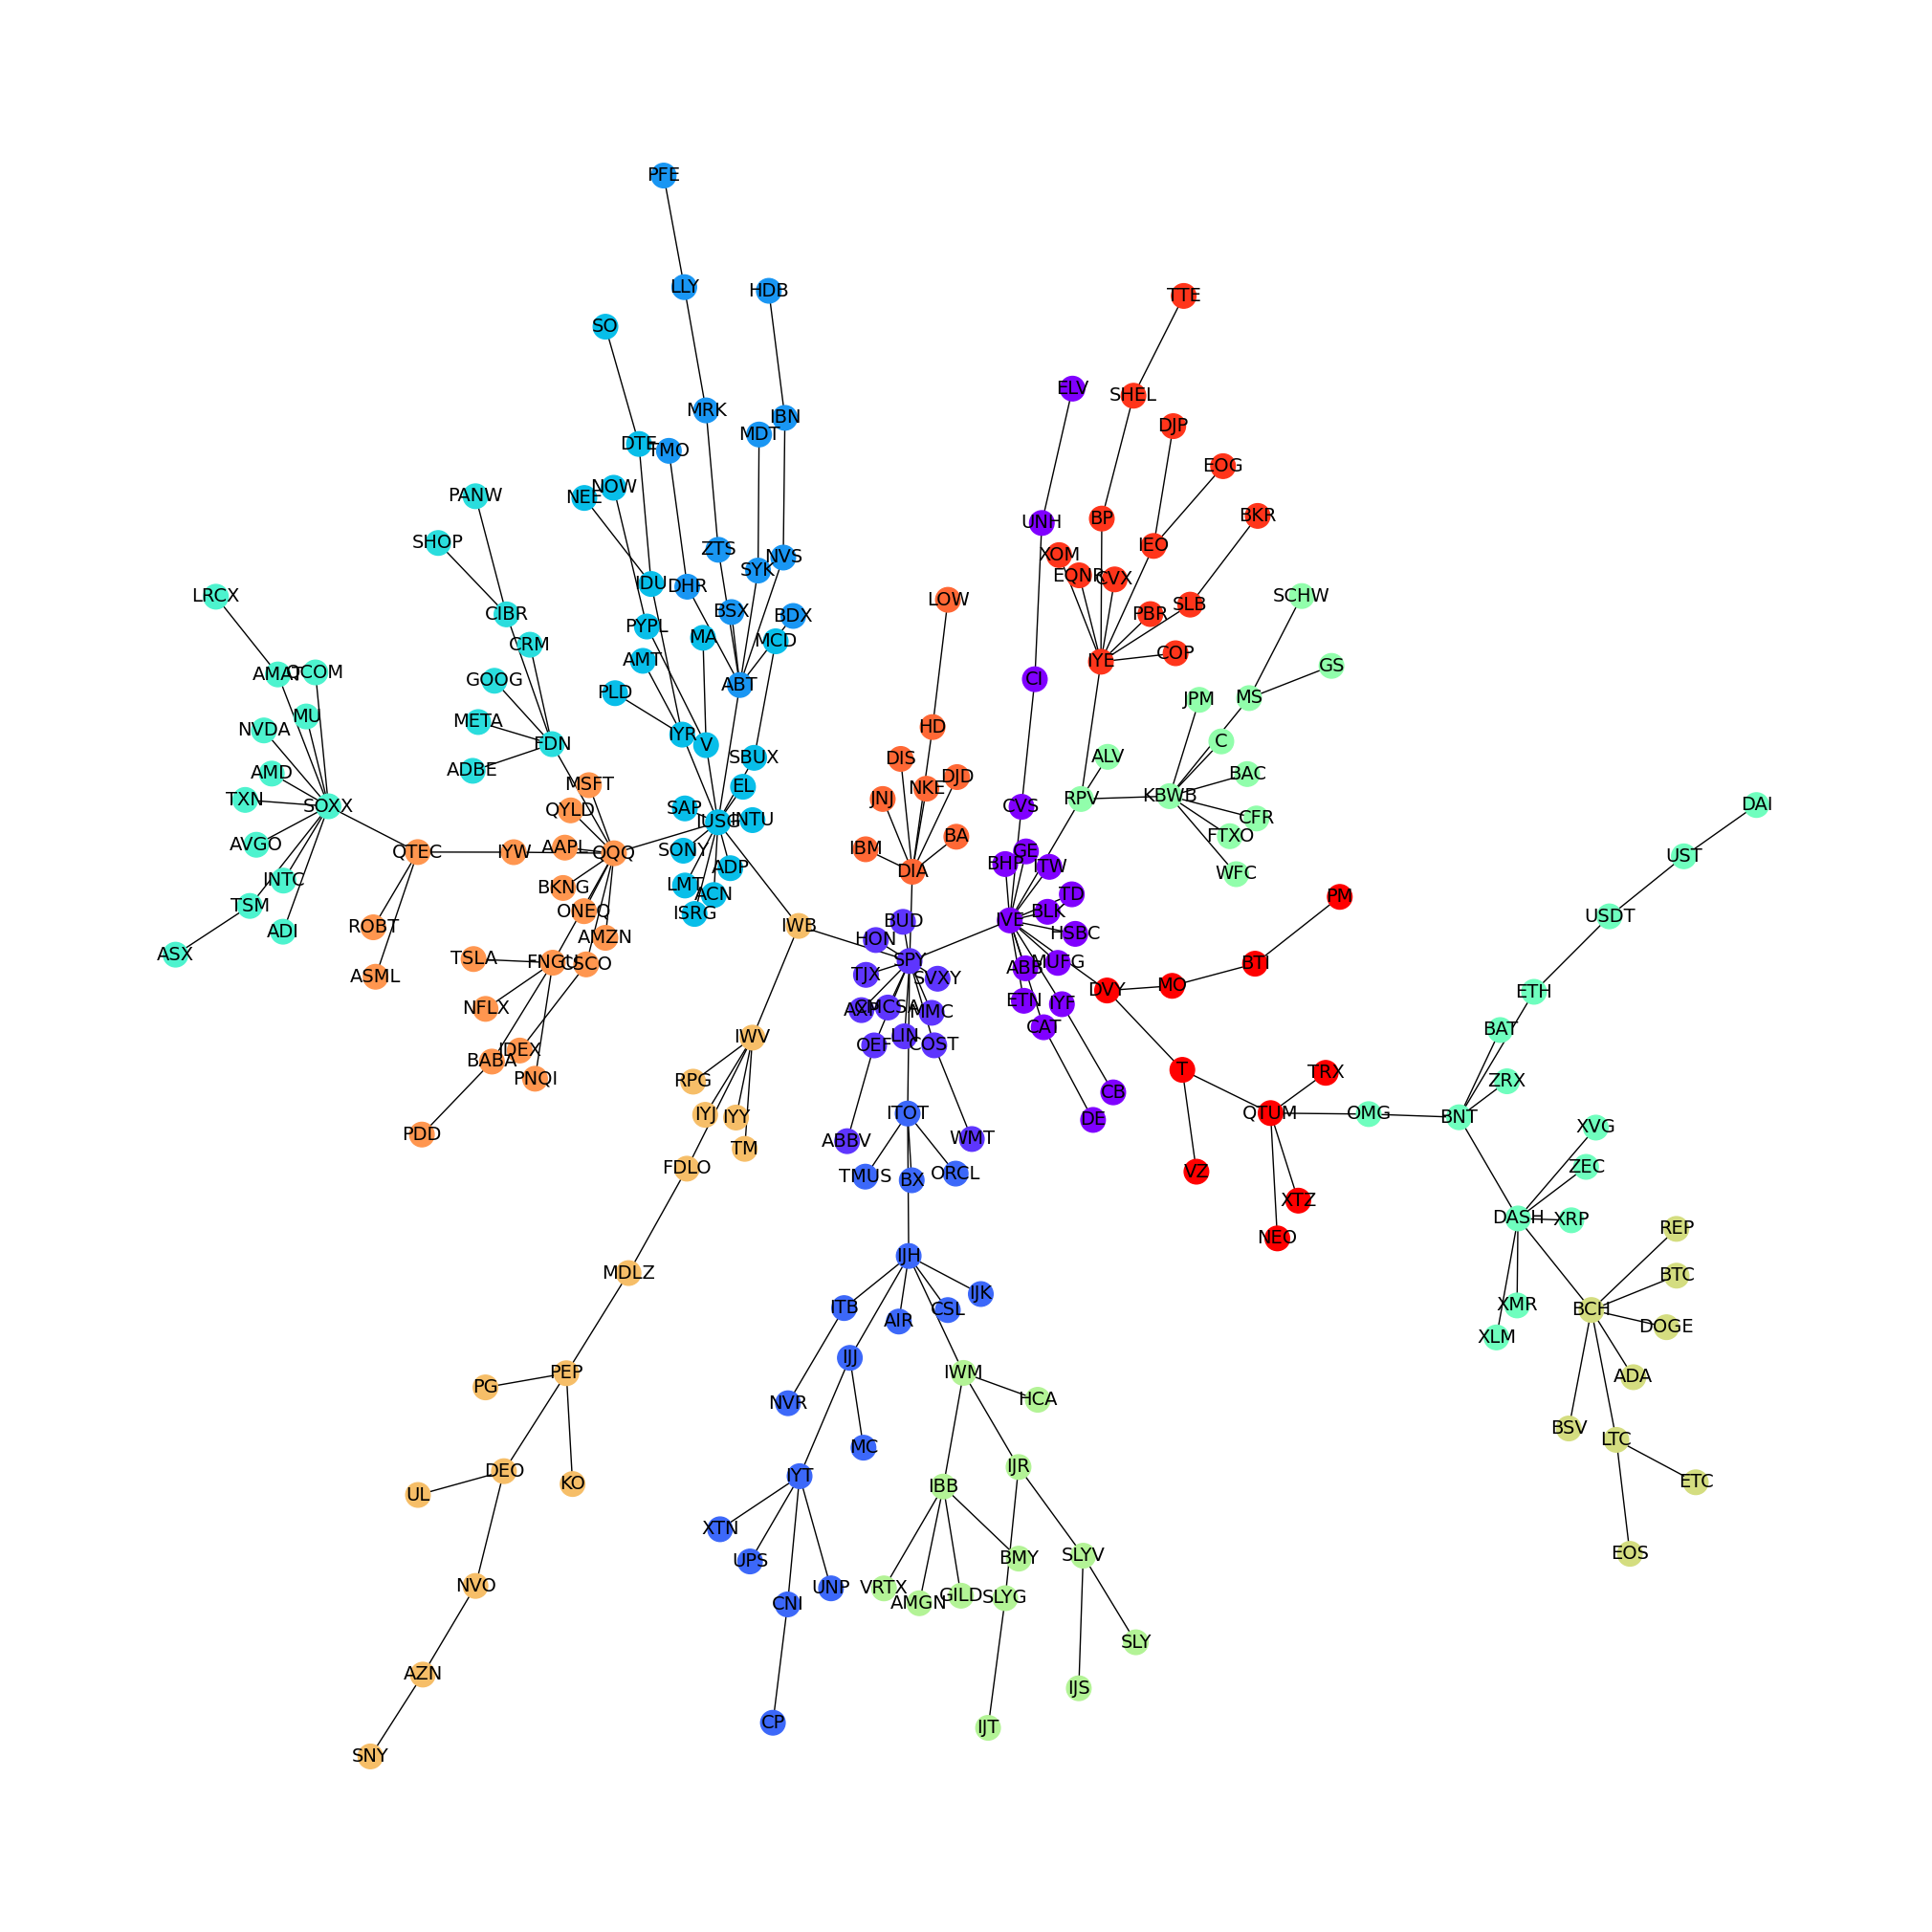

In [ ]:
plt.figure(figsize = (20,20))
pos = nx.kamada_kawai_layout(mst_graph) # Set up the layout of the graph
cmap = cm.get_cmap('rainbow', max(louvain_partition.values()) + 1) # color the nodes according to their partition
widths = list(nx.get_edge_attributes(mst_graph,'width').values())
# Draw the graph and the Louvain community detection result
nx.draw(mst_graph, pos, node_size=340, cmap=cmap, node_color=list(louvain_partition.values()), with_labels = True, font_color= 'k', font_size = 14)
